# Predicting glycosylated hemoglobin (HbA1c) levels from continuous glucose monitoring (CGM) devices

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rashecl/predict_HbA1c/blob/master/Predict_HbA1c.ipynb)

In [19]:
import os
import timeit
from IPython.display import clear_output, Image, display
import pandas as pd
from ipywidgets import interactive, IntSlider, Dropdown, IntRangeSlider, Layout, Checkbox
from pandas.api.types import CategoricalDtype
import numpy as np
from datetime import datetime,timedelta
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pickle
from warnings import filterwarnings
import statsmodels.api as sm
from sklearn.model_selection import ShuffleSplit, train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ElasticNetCV, LassoCV, LinearRegression
filterwarnings(action='ignore')
import sys
if sys.platform == 'linux': # As in Google Colab
    ! sudo apt-get install git-lfs
    ! git clone https://github.com/rashecl/predict_HbA1c.git
    ! pip install lmfit
    sys.path.append('/content/Predict_HbA1c')
    os.chdir('predict_HbA1c')
    ! git-lfs pull

def update_progress(numerator, denominator=1, taskName = 'Progress'):
    bar_length = 20
    block = int(round(bar_length * (numerator/denominator)))
    text = taskName + ": [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), (numerator/denominator) * 100)
    if (numerator % 10 ==0) or (numerator==denominator):
        clear_output(wait=True)
        print(text)


## 1) Introduction

Diabetes is a condition associated with insulin resistance (Type II) or insufficiency (Type I), which leads to impaired glucose homestasis. High concentrations of glucose lead to diabetes comorbidities like diabetic retinopathy and neuropathy. While blood glucose measurements give a snapshot of the current blood glucose concentration, glycosylated hemoglobin (HbA1c) is a useful biomarker that reflects the glucose burden over the span of months. HbA1c forms when glucose binds to hemoglobin and through a cascade of steps to form an irreversible advanced glycation end-product. Simliarly, glucose forms advanged glycation end-products with other proteins, which can impair their function. Individuals with diabetes should get their HbA1c levels assessed every 6 months at the clinic to understand how they have been managing their blood sugar levels; however, with the advent of continous glucose monitoring (CGM) devices that show individuals' glucose concentrations every 5 minutes, it should be possible to infer HbA1c levels. 

**The goal of this project is to use CGM data from the [REPLACE-BG](https://www.ncbi.nlm.nih.gov/pubmed/28209654) dataset to predict HbA1c levels.** This would provide real-time feedback to individuals with diabetes and their physicians on how they have been managing their blood sugar levels without necessarily getting an HbA1c test at the clinic. *Interestingly, this work suggests a framework to assess glucose associated toxicity in real-time.* 

### **Goal:** 
Estimate $f$: <br>
<center>$\LARGE HbA1c = f(\textbf{GLU})$<br>

<center>, where $\textbf{GLU}$ is the CGM data prior to the test</center>

In addition to predicting HbA1c levels with CGM data, we'll also look at other features (medical conditions, medications, and demographic) to see if there are other features to improve our HbA1c predictions.  

## 2) Data wrangling


#### HbA1c test results:
First, we will extract **the target variable that we are trying to predict (i.e. HbA1c test results)**. We will select HbA1c results that have at least 90 days of CGM data preceding it since HbA1c tests are thought to reflect the 3-month average blood sugar levels.

In [2]:
HbA1c_results = pd.read_csv('Data/HLocalHbA1c.txt',delimiter='|')[['PtID', 'HbA1cTestDtDaysAfterEnroll', 'HbA1cTestRes']]
HbA1c_results.columns= ['PtID', 'Day', 'HbA1c']
HbA1c_results = HbA1c_results = HbA1c_results[~np.isnan(HbA1c_results.HbA1c) & (HbA1c_results['Day'] > 90)].sort_values('PtID').reset_index(drop=True)
HbA1c_results

,PtID,Day,HbA1c
0,2,151.0,6.3
1,2,242.0,6.2
2,3,168.0,6.8
3,3,258.0,7.1
4,5,113.0,6.3
...,...,...,...
443,291,166.0,7.0
444,292,114.0,6.1
445,292,191.0,6.8
446,293,192.0,7.6


#### CGM data:
Next, we'll wrangle the continous glucose measurements for the 226 subjects starting from the date of enrollment.

In [95]:
if os.path.exists('Data/ReplaceBG_2.p'):
    [CGM,BGM] = pickle.load(open("Data/ReplaceBG_2.p", "rb"))
else:
    print('This should take about 3.5 minutes if everything goes according to plan...')
    start_time = timeit.default_timer()
    CGM = pd.read_csv('Data/HDeviceCGM.txt', delimiter='|')
    CGM = CGM[(CGM.RecordType=='CGM') & (CGM.GlucoseValue>=40) & (CGM.GlucoseValue<=400)]
    CGM = CGM[CGM.DeviceDtTmDaysFromEnroll >= 0][['PtID', 'DeviceDtTmDaysFromEnroll', 'DeviceTm', 'GlucoseValue']].reset_index(drop=True)
    CGM.columns = ['PtID', 'DaysFromEnroll', 'Time', 'GlucoseValue']
    CGM = CGM[CGM.PtID.apply(lambda x: x not in excludeIds)]
    elapsed = timeit.default_timer() - start_time
    print('Loaded CGM data...{:.2f}s'.format(elapsed))

    CGM.Time = CGM.Time.apply(pd.to_timedelta)
    elapsed = timeit.default_timer() - start_time
    print('Converted CGM to timedelta...{:.2f}s'.format(elapsed))

    CGM.sort_values(['PtID', 'DaysFromEnroll', 'Time'], inplace=True)
    elapsed = timeit.default_timer() - start_time
    CGM.reset_index(drop=True, inplace=True)
    CGM['WeeksFromEnroll'] = CGM.DaysFromEnroll.apply(lambda x: x//7)
    
    
    print('Sorted CGM data...Finished! {:.2f}s:'.format(elapsed))

    BGM = pd.read_csv('Data/HDeviceBGM.txt', delimiter='|')
    elapsed = timeit.default_timer() - start_time
    print('Loaded BGM data...{:.2f}'.format(elapsed))

    BGM = BGM[BGM.PtID.apply(lambda x: x not in excludeIds)]
    BGM = BGM[ (BGM.DeviceDtTmDaysFromEnroll >= 0) & (BGM.DeviceDtTmDaysFromEnroll < 1000) ][['PtID', 'DeviceDtTmDaysFromEnroll', 'DeviceTm', 'GlucoseValue']]
    BGM = BGM[BGM['RecordType']=='BGM']
    BGM.columns = ['PtID', 'DaysFromEnroll', 'Time', 'GlucoseValue']

    BGM.DeviceTm = BGM.Time.apply(pd.to_timedelta)
    elapsed = timeit.default_timer() - start_time
    print('Converted BGM to timedelta...{:.2f}'.format(elapsed))

    BGM.sort_values(['PtID', 'DaysFromEnroll', 'Time'], inplace=True)
    BGM.reset_index(drop=True, inplace=True)
    BGM['WeeksFromEnroll'] = BGM.DaysFromEnroll.apply(lambda x: x//7)
    
    elapsed = timeit.default_timer() - start_time
    print('Sorted BGM data...Finished!{:.2f}s'.format(elapsed))
    pickle.dump([CGM,BGM], open("Data/ReplaceBG_2.p", "wb"))
display(CGM)

,PtID,DaysFromEnroll,Time,GlucoseValue,WeeksFromEnroll
0,2,0,10:41:29,143.0,0
1,2,0,10:46:29,151.0,0
2,2,0,10:51:29,149.0,0
3,2,0,10:56:29,140.0,0
4,2,0,11:01:29,149.0,0
...,...,...,...,...,...
13358635,293,192,09:38:07,186.0,27
13358636,293,192,09:43:07,186.0,27
13358637,293,192,09:48:07,183.0,27
13358638,293,192,09:53:07,178.0,27


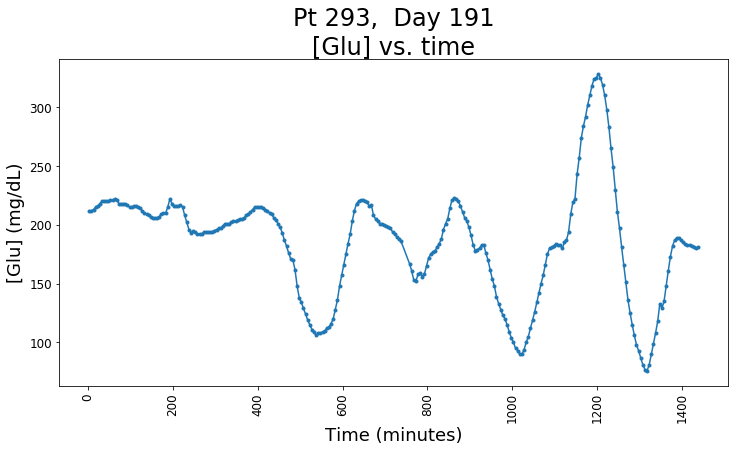

In [94]:
# Example CGM data:
plt.figure(figsize=(12,6))
plt.plot(CGM.query('DaysFromEnroll==191 & PtID==293').Time.astype('timedelta64[m]'),
         CGM.query('DaysFromEnroll==191 & PtID==293').GlucoseValue, marker='.')
plt.xticks(rotation=90)
plt.xlabel('Time (minutes)', fontsize=18)
plt.ylabel('[Glu] (mg/dL)', fontsize=18)
plt.title('Pt 293,  Day 191\n[Glu] vs. time', fontsize=24)
plt.show()

## 3) Data exploration

### GUI to explore individual subjects CGM data and HbA1c test days

In [39]:
def plotPtData(ptID = 3, day_range=[127,127], show90DayMeanDist=False):
    fig=plt.figure(figsize=(8,8))
    grid= plt.GridSpec(5,2)
    mean_ax = fig.add_subplot(grid[0, :])
    sns.lineplot(x='DaysFromEnroll', y='GlucoseValue', data=CGM[(CGM['PtID']==ptID)].groupby('DaysFromEnroll').mean().reset_index(),
                ax=mean_ax)
    mean_ax.set_ylabel('mean [GLU]\n(daily)', fontsize=12)
    
    mean_ax.fill_between([day_range[0],day_range[1]],[300,300],color='grey', alpha=0.35)
    test_days= HbA1c_results[HbA1c_results.PtID == ptID].Day
    mean_ax.scatter(test_days, [0]*len(test_days), marker='^',color='g', label='HbA1c test')
    mean_ax.set_xlim([0,330])
    mean_ax.set_xlabel('Days from enrollment', fontsize=12)
    mean_ax.legend()
    
    counts_ax = fig.add_subplot(grid[1, :])
    sns.scatterplot(x='DaysFromEnroll', y='GlucoseValue', data=CGM[(CGM['PtID']==ptID)].groupby('DaysFromEnroll').count().reset_index(),
                marker='.',ax=counts_ax)
    counts_ax.set_ylabel('# of data\npoints', fontsize=12)
    counts_ax.set_xlabel('Days from enrollment', fontsize=12)
    counts_ax.fill_between([day_range[0],day_range[1]],[300,300],color='grey', alpha=0.35)
    counts_ax.plot([0,330],[72,72],linestyle='--')
    counts_ax.set_xlim([0,330])
    counts_ax.set_title('# of data points', fontsize=16)
    
    dist_ax = fig.add_subplot(grid[2:, :])
    gluVals = CGM[(CGM['PtID']==ptID) & (CGM['DaysFromEnroll']>= day_range[0]) & (CGM['DaysFromEnroll']<= day_range[1]) ].GlucoseValue
    sns.distplot(gluVals, bins=np.linspace(40,400,36))    
    if show90DayMeanDist:
        test_day = day_range[1]
        df = CGM[(CGM.PtID == PtID) & ((test_day-CGM.DaysFromEnroll)>0)][['PtID', 'DaysFromEnroll', 'GlucoseValue']]
        df['DaysFromTest'] = test_day - df['DaysFromEnroll']
        df=df[df.DaysFromTest <=90]
        glu_conc_bins = np.arange(45,400,10)
        fittedGlu = stats.lognorm(*stats.lognorm.fit(df.GlucoseValue))
        dist_ax.scatter(glu_conc_bins, fittedGlu.pdf(x=glu_conc_bins)*.1/np.sum(fittedGlu.pdf(x=glu_conc_bins)),marker='.')

    dist_ax.set_xlim([0,400])
    dist_ax.set_title('Glucose probability distribution', fontsize=20)
    dist_ax.set_ylabel('Probability', fontsize=16)
    dist_ax.set_xlabel('[GLU]', fontsize=16)
    plt.tight_layout()
    return

subjectDropdown = Dropdown(options=CGM['PtID'].unique(),
                           value=3)
day_rangeSlider = IntRangeSlider(value=[127, 127], min=0, max=330, step=1, continuous_update=False, layout=Layout(width='65%', height='80px'))
interactive(plotPtData,
           ptID=subjectDropdown,
           day_range= day_rangeSlider)


interactive(children=(Dropdown(description='ptID', index=1, options=(2, 3, 5, 7, 8, 9, 10, 11, 14, 15, 16, 17,…

### Determine how many days had insufficient GLU measurements (<72 data points ~ 6 hours):

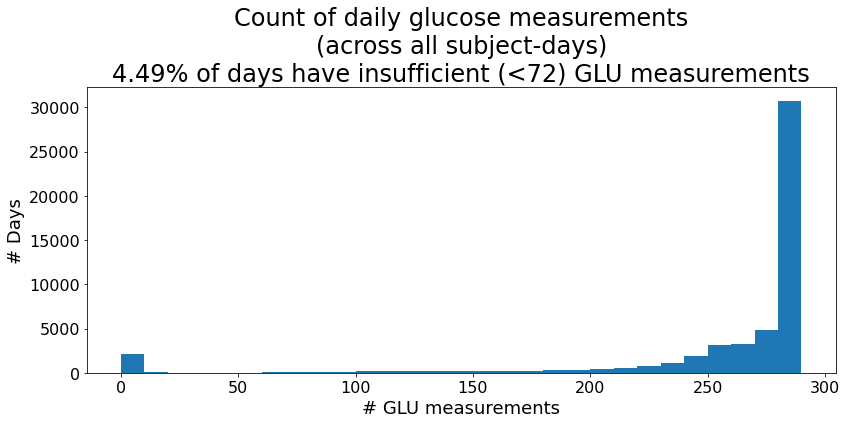

In [40]:
if os.path.exists('PresentationFigs/dailyMeasurementCounts.png'):
    img = Image(filename='PresentationFigs/dailyMeasurementCounts.png')
    display(img)
else:
    ans = input(prompt="Do you want to run this analysis (Y/N)? It will take a long time (~1 hour).")
    if ans.lower() == 'y':
        nDataPoints=[]
        allPtIds = CGM.PtID.unique()
        for ptID in allPtIds[0:30]:
            ptTrialLen = CGM[CGM.PtID == ptID].DaysFromEnroll.max()
            for d in range(ptTrialLen+1):
                nDataPoints.append(np.sum((CGM.PtID == ptID) & (CGM.DaysFromEnroll==d)))
                update_progress(numerator=d, denominator=ptTrialLen, taskName='PtID {:1.0f} (max PtID= {:1.0f}): Progress'.format(ptID, allPtIds.max()))
        
        plt.figure(figsize=(12,6))
        plt.hist(nDataPoints, bins=range(0,300,10))
        plt.title('Count of daily glucose measurements\n(across all subject-days)\n{:.2f}% of days have insufficient (<72) GLU measurements'.format(100*np.sum(np.array(nDataPoints)<=72)/len(nDataPoints)),FontSize=24)
        plt.ylabel('# Days',FontSize=18)
        plt.xlabel('# GLU measurements',FontSize=18)
        plt.xticks(fontsize=16); plt.yticks(fontsize=16) 
        plt.tight_layout()
        plt.savefig('PresentationFigs/dailyMeasurementCounts.png')
    else:
        pass
    

### GLU probablity distributions (gluPDs) over the last 90 days:

A useful method to represent CGM data is daily probablity distributions. This not only allows for a nice visualiztion, but provides us with a substrate that we can map to HbA1c levels.

In [41]:
def get90DayCGMdata(PtID=2, test_day=100, showPlot=False):
#     PtID=2; test_day=100;
    if np.sum(CGM.PtID == PtID) == 0:
        print('No data for this PtID')
        return np.zeros(shape=(90,36))
    gluPDF_90d=np.zeros(shape=(90,36))
    df = CGM[(CGM.PtID == PtID) & ((test_day-CGM.DaysFromEnroll)>0)][['PtID', 'DaysFromEnroll', 'GlucoseValue']]
    df['DaysFromTest'] = test_day - df['DaysFromEnroll']
    df=df[df.DaysFromTest <=90]
    calculatedMeanGluDist_bool = False
    glu_conc_bins = np.arange(45,400,10)
    imputedDays = []
    for d in range(1,91):
        if np.sum(df.DaysFromTest==d) < 72:
            imputedDays.append(d)
            clear_output(wait=True)
            print('Imputing data for Pt {:1.0f} on {:1.0f} days prior to test.'.format(PtID, d))
            if not calculatedMeanGluDist_bool:
                fittedGlu = stats.lognorm(*stats.lognorm.fit(df.GlucoseValue))
                meanGluDist = fittedGlu.pdf(x=glu_conc_bins)/np.sum(fittedGlu.pdf(x=glu_conc_bins))
#                 print('MeanGluDist: ', meanGluDist)
                gluPDF_90d[d-1,:] = meanGluDist
                calculatedMeanGluDist_bool= True
            else: 
                gluPDF_90d[d-1,:] = meanGluDist
#                 print('MeanGlu rep: ', meanGluDist)
        else:
            currGLUpdf = np.histogram(df[df.DaysFromTest==d].GlucoseValue, bins=36, range=(40,400), density=True)[0]
            currGLUpdf = currGLUpdf/np.sum(currGLUpdf)
            gluPDF_90d[d-1,:] = currGLUpdf
        update_progress(numerator=d, denominator=91, taskName='Creating temporal GLU pdf for Pt{:1.0f}'.format(PtID))
    
    if showPlot:
        fig,ax = plt.subplots(figsize=(12,8))
        sns.heatmap(gluPDF_90d, ax=ax)
        ax.set_xlabel('[GLU]', fontsize=16)
        ax.set_ylabel('Days from HbA1c test', fontsize=16)
        for dd in imputedDays:
            rect = mpl.patches.Rectangle((0,dd), width = 50, height = 1, color='y', label='imputed data', alpha=.05)
            ax.add_patch(rect)

        ax.set_xticks(range(1,len(glu_conc_bins),4))
        ax.set_xticklabels(glu_conc_bins[1:len(glu_conc_bins):4], fontsize=16)
        ax.set_yticks(range(0,91,5))
        ax.set_yticklabels(range(0,91,5), fontsize=16)
        plt.legend(labels=['Imputed data'])
        plt.title("Pt_{:1.0f}'s temporal GLU PDF\n aligned to day {}".format(PtID, test_day))
        plt.show()
        
    return gluPDF_90d

subjectDropdown = Dropdown(options=CGM['PtID'].unique(), value=5)
test_day_slider = IntSlider(value=180, min=90, max=330, step=1, continuous_update=False, layout=Layout(width='65%', height='80px'))
showPlotCheckbox= Checkbox(value=True)
interactive(get90DayCGMdata,
           PtID=subjectDropdown,
           test_day= test_day_slider, 
           showPlot = showPlotCheckbox)

# gluPDF_90d = get90DayCGMdata(PtID=5, test_day=150, showPlot=True) 


interactive(children=(Dropdown(description='PtID', index=2, options=(2, 3, 5, 7, 8, 9, 10, 11, 14, 15, 16, 17,…

## Modeling: 
#### Goal
* Estimate $f$: <br>
<center> $\Large HbA1c = f(\textbf{gluPDs}) $ <br>
<br><br>, where 
<br>$\Large \textbf{gluPDs}$ $= \begin{bmatrix}
P([GLU])_{d_1g_1} & P([GLU])_{d_1g_2} & ... & P([GLU])_{d_1g_{36}}\\
P([GLU])_{d_2g_1} & . & . & P([GLU])_{d_2g_36}\\
\vdots & . & . & \vdots\\
P([GLU])_{d_90g_1} & . & . & P([GLU])_{d_{90}g_{36}}
\end{bmatrix} $

#### Assumptions 
* HbA1c levels are monotonically related to [GLU] (similar to Michaelis-Menten):
    
<center> $\Large w_g \; = \; \frac{1}{1+\frac{k_m}{[GLU]}}$ , <br>
    <br> where $\small [GLU] = g_{bin} * 10 + 45 $ </center>

In [42]:
glu_conc_bins = np.arange(45,400,10)
km = 200
def w_g_func(km = km, glu_conc_bins = glu_conc_bins):
    return 1/(1+km/glu_conc_bins)

* Glucose levels from the distant past have less influence on current HbA1c levels:

<center> $\Large w_d \; = \; e^{-\frac{d-1}{\tau}}$ </center> 

In [43]:
nDays = 90
tau=45
def w_d_func(tau = tau, nDays=nDays):
    days = np.arange(1,nDays+1)
    return np.exp(-(days-1)/tau)

#### Temporal [GLU] weights:
<center>
$ \textbf{W} (k_m, \tau) = 
\frac{\begin{bmatrix}
w_{d_1}w_{g_1} & w_{d_1}w_{g_2} & ... & w_{d_1}w_{g_{36}}\\
w_{d_2}w_{g_1} & . & . & w_{d_2}w_{g_{36}}\\
\vdots & . & . & \vdots\\
w_{d_{90}}w_{g_1} & . & . & w_{d_90}w_{g_{36}}
\end{bmatrix}}{\sum\limits_{d=1}^{90}\sum\limits_{g=1}^{36} w_d*w_g} $
</center>

In [44]:
def W_func(km = km, tau = tau):
    w_d = w_d_func(tau = tau)
    w_g = w_g_func(km = km)
    W = np.zeros((len(w_d), len(w_g)))
    for d in range(len(w_d)):
        W[d,:] = w_g*w_d[d]
    return W/np.sum(W)

#### Viz of how km and tau affects W

In [45]:
def plotW(km=km, tau=tau):      
    fig=plt.figure(figsize=(12,8))
    grid= plt.GridSpec(2,3)
    w_g_ax = fig.add_subplot(grid[0, 0])
    w_d_ax = fig.add_subplot(grid[1, 0])
    W_ax = fig.add_subplot(grid[:, 1:])
    
    w_g=w_g_func(km=km)
    w_g_ax.plot(glu_conc_bins, w_g)
    w_g_ax.set_ylim([0,1])
    w_g_ax.set_xlabel('[GLU]', fontsize=16)
    w_g_ax.set_ylabel('weight    or\nrel. rate of Hb glycation', fontsize=16)
    
    days = np.arange(1,nDays+1)
    w_d=w_d_func(tau=tau)
    w_d_ax.plot(days, w_d)
    w_d_ax.set_xlabel('days preceding test', fontsize=16)
    w_d_ax.set_ylabel("weight     or\n rel. influence on HbA1c test", fontsize=16)

    sns.heatmap(W_func(km=km, tau=tau), ax = W_ax)
    W_ax.set_xticks(range(1,len(glu_conc_bins),4))
    W_ax.set_xticklabels(glu_conc_bins[1:len(glu_conc_bins):4], fontsize=16)
    W_ax.set_yticks(range(0,nDays+1,5))
    W_ax.set_yticklabels(range(0,nDays+1,5), fontsize=16)
    W_ax.set_xlabel('[GLU]', fontsize=16)
    W_ax.set_ylabel('Days from HbA1c test', fontsize=16)
    W_ax.set_title('Temporal [GLU] weights (W)', fontsize=24)
    plt.tight_layout()
    plt.show()
    return
 
km_slider=IntSlider(value=150, min=20, max=490, continuous_update=False)
tau_slider=IntSlider(value=50, min=5, max=120, continuous_update=False)
interactive(plotW,
           km=km_slider,
           tau=tau_slider)
#     grid = plt.GridSpec(4, 4)


interactive(children=(IntSlider(value=150, continuous_update=False, description='km', max=490, min=20), IntSli…

<center> $ \large{Hba1c}(k_m, \tau) = \beta_0 + \beta_1 \textbf{W} (k_m, \tau) \circ \textbf{gluPDs} + \epsilon$ 
<br><br><br><br>
<center> $ \large{Hba1c}(k_m, \tau) = \beta_0 + \beta_1 vec(\textbf{W}) \cdot vec(\textbf{gluPDs}) + \epsilon $ </center>

### Determine:

<center> $ \Large argmin_{𝑘𝑚,𝜏, 𝛽_0,𝛽_1}\sum\limits_{i=1}^{N}𝜖^2$
<br>, where N = # of HbA1c tests

    

# Machine Learning (linear model) 

### Create feature matrix and target vector:

In [46]:
if os.path.exists('Data/ML.p'):
    [X,y] = pickle.load(open("Data/ML.p", "rb"))
else:
    start_time = timeit.default_timer()
    X = np.zeros((len(HbA1c_results), 90*36))
    for i in range(len(HbA1c_results)):
        PtID = HbA1c_results['PtID'].iloc[i]
        test_day = HbA1c_results['Day'].iloc[i]
        X[i,:] = get90DayCGMdata(PtID=PtID, test_day=test_day).ravel()
    y = HbA1c_results.HbA1c
    # Some of the CGM data was missing... so remove those!
    y = y[X.sum(axis=1)!=0].to_numpy()
    X = X[X.sum(axis=1)!=0].to_numpy()
    
    elapsed = timeit.default_timer() - start_time
    pickle.dump([X,y], open("Data/ML.p", "wb"))
    print('Created feature matrix! It took {:.2f}s'.format(elapsed))
    
print('# of Target variables: ', len(HbA1c_results))
print('Size of Feature matrix: ', X.shape)
print('Size of target vector: ', len(y))


# of Target variables:  448
Size of Feature matrix:  (441, 3240)
Size of target vector:  441


#### Shufffle and split data into training and test sets:

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

## Determine optimal set of parameters by minimizing loss function

### Perform grid search for 𝛕 and km: 

In [48]:
def mse(p):
    km=p[0]
    tau=p[1]
    lm = sm.OLS(y_train, exog=sm.add_constant(X_train.dot(W_func(km=km,tau=tau).ravel())))
    res = lm.fit()
    return res.mse_resid

kms = np.arange(50, 1000, 1)
taus = np.arange(10, 100,1)

# 29.34, 490.45
tau_grid, km_grid = np.meshgrid(taus, kms)
zgrid = np.zeros((len(kms), len(taus)))
for i, km in enumerate(kms):
    for j, tau in enumerate(taus):
        zgrid[i,j] = mse([km,tau])

#### Visualize the results of the grid search

In [49]:
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 

def d3plot(a=45,b=-45):
    fig = plt.figure(figsize=(15,7.5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.view_init(a, b)
#     ax1.plot_surface(tau_grid, km_grid, zgrid, cmap='terrain')
    ax1.plot_wireframe(tau_grid, km_grid, zgrid, cmap='terrain')
    
    
    ax2= fig.add_subplot(122)
    ax2.contourf(tau_grid, km_grid, zgrid, cmap='terrain')
    loc = np.where(zgrid == np.amin(zgrid))
    ax2.scatter(tau_grid[loc], km_grid[loc], color='white')
    
    ax2.set_xlabel('tau', fontsize=18)
    ax2.set_ylabel('km', fontsize=18)
    ax2.set_title('MSE countour plot', fontsize=24)
        
        
    ax1.set_xlabel('tau', fontsize=18)
    ax1.set_ylabel('km', fontsize=18)
    ax1.set_zlabel('mse', fontsize=20)
    ax1.set_title('Grid search for tau and km', fontsize=24)
    plt.tight_layout()
    plt.show()
    
a_slider = IntSlider(value=45, min=30, max = 90, continuous_update=False)
b_slider = IntSlider(value=-45, min=-60, max = 45, continuous_update=False)
interactive(d3plot,
           a= a_slider,
           b= b_slider)


interactive(children=(IntSlider(value=45, continuous_update=False, description='a', max=90, min=30), IntSlider…

Unfortunately, there doesn't seem to be a great unique solution for km. There is a very flat loss landscape. 


### Bootstrap estimate for 𝛕 after assuming km=800 mg/dL  : 

In [50]:
rs=ShuffleSplit(n_splits=100, train_size=.8)
tau_results =  []
for train_idxs, cval_idxs in rs.split(y_train):
    X_train_tmp = X_train[train_idxs]
    y_train_tmp = y_train[train_idxs]
    def mse(p):
        tau=p[0]
        km=800
        lm = sm.OLS(y_train_tmp, exog=sm.add_constant(X_train_tmp.dot(W_func(km=km,tau=tau).ravel())))
        res = lm.fit()
        return res.mse_resid
    res2 = minimize(mse, [20], method='Nelder-Mead', options={'ftol': 1e-7, 'disp': False})
    tau_results.append(res2.x)
print('𝛕 : {:.2f} ± {:.2f}'.format(np.mean(tau_results), np.std(tau_results)/np.sqrt(len(tau_results))))


𝛕 : 32.00 ± 0.46


Next, estimate $\beta_0 \; and \; \beta_1$

In [51]:
X_sm = sm.add_constant(X_train.dot(W_func(km=800,tau=np.mean(tau_results)).ravel()))
# X_sm = X_train.dot(W_func(km=28.83,tau=219.41).ravel())
lm = sm.OLS(y_train, exog=X_sm, hasconst = True)
res = lm.fit()
beta0 = res.params[0] 
beta1 = res.params[1]
print('beta0 : {:.2f}'.format(beta0))
print('beta1: {:.2f}'.format(beta1))
res.summary()

beta0 : 2.22
beta1: 220.06


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     492.0
Date:                Thu, 21 May 2020   Prob (F-statistic):           3.11e-67
Time:                        22:35:41   Log-Likelihood:                -200.09
No. Observations:                 330   AIC:                             404.2
Df Residuals:                     328   BIC:                             411.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2220      0.219     10.169      0.000       1.792       2.652
x1           220.0594      9.921     22.181      0.000     200.542     239.577
==============================================================================
Omnibus:                       31.627   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.258
Skew:                          -0.434   Prob(JB):                     1.37e-18
Kurtosis:                       5.287   Cond. No.                         405.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Final model: 
<center> $ \large{Hba1c} \approx 2.23 + 219.82 \textbf{W} (k_m=800, \tau = 30.84) \circ \textbf{gluPDs} + \epsilon$ 


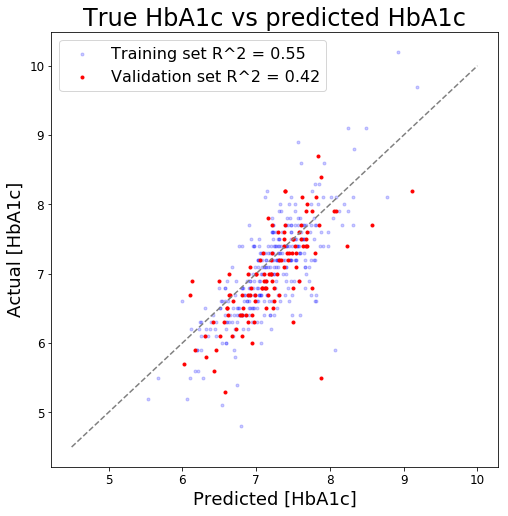

In [52]:
X_test_transformed = X_test.dot(W_func(km=500,tau=np.mean(tau_results)).ravel())
X_train_transformed = X_train.dot(W_func(km=500,tau=np.mean(tau_results)).ravel())
plt.figure(figsize=(8,8))
plt.scatter(beta0 + beta1* X_train_transformed, y_train,color='blue', marker='.', alpha=.2 , 
            label="Training set R^2 = {:.2f}".format(r2_score(y_train, beta0 + beta1* X_train_transformed)))
plt.scatter(beta0 + beta1* X_test_transformed, y_test,color='red', marker='.', 
            label="Validation set R^2 = {:.2f}".format(r2_score(y_test, beta0 + beta1* X_test_transformed)))
# plt.scatter(X_sm, y_train,color='red')
plt.plot(np.linspace(4.5,10,10),np.linspace(4.5,10,10),linestyle='--', color='grey')
plt.xlabel("Predicted [HbA1c]", fontsize=18)
plt.ylabel("Actual [HbA1c]", fontsize=18)
plt.title("True HbA1c vs predicted HbA1c", fontsize=24)
plt.legend(fontsize=16)
plt.show()

# End of presentation

## 99) Exploratory Data Analysis

### Wrangle the patient associated data
(Demographic data, Medical conditions, HbA1c test results, CGM, and BGM data)

In [23]:
## First gather all the patient associated data (except for the glucose measurements): 

if os.path.exists('Data/ReplaceBG_1.p'):
    [patientData, medicalConditions, commonMedCond_counts, medications, commonMed_counts, edu_order, inc_order, excludeIds, HbA1c] = pickle.load(open("Data/ReplaceBG_1.p", "rb"))
else: 
    ptWithdrawal = pd.read_csv('Data/HPostRandPtFinalStatus.txt',delimiter='|')
    excludeIds = list(ptWithdrawal.PtID.unique())
#     excludeIds.append(91) # Didn't have Week26 HbA1c

    patientMeta=pd.read_csv('Data/HPtRoster.txt', delimiter='|')
    patientMeta = patientMeta[patientMeta.PtID.apply(lambda x: x not in excludeIds)]
    patientMeta.drop(columns=['RecID', 'SiteOrig', 'SiteID', 'RandDtDaysAfterEnroll','PtStatus'], inplace=True)
    patientMeta.columns = ['PtID', 'TrtGroup', 'Age']

    screening = pd.read_csv('Data/HScreening.txt',delimiter='|') # This also contains demographic information
    screening = screening[screening.PtID.apply(lambda x: x not in excludeIds)]
    screening = screening[['PtID', 'EduLevel', 'Gender', 'Race', 'DiagAge', 'AnnualInc', 'Weight', 'Height']]
    screening['BMI'] = screening.Weight/(screening.Height*.01)**2
    edu_order = ['High school graduate/diploma/GED',
     'Some college but no degree',
     'Associate Degree',
     "Bachelor's Degree",
     "Master's Degree",
     'Professional Degree',
     'Doctorate Degree']

    inc_order = ['Less than $25,000',
                 '$25,000 - $35,000',
                 '$35,000 - less than $50,000',
                 '$50,000 - less than $75,000',
                 '$75,000 - less than $100,000',
                 '$100,000 - less than $200,000', 
                 '$200,000 or more']

    edu_type = CategoricalDtype(categories=edu_order, ordered=True)
    inc_type = CategoricalDtype(categories=inc_order, ordered=True)

    screening['EduLevel'] = screening.EduLevel.astype(edu_type)
    screening['AnnualInc'] = screening.AnnualInc.astype(inc_type)

    HbA1c = pd.read_csv('Data/HLocalHbA1c.txt',delimiter='|')
    HbA1c = HbA1c[HbA1c.PtID.apply(lambda x: x not in excludeIds)]
    HbA1c = HbA1c.pivot(index='PtID', columns='Visit', values=['HbA1cTestRes', 'HbA1cTestDtDaysAfterEnroll']).reset_index()
    HbA1c.columns = HbA1c.columns.to_flat_index()
    HbA1c.columns = ['PtID', 'Randomization_HbA1c', 'Screening_HbA1c','Week13_HbA1c', 'Week26_HbA1c',
           'Randomization_HbA1c_day','Screening_HbA1c_day','Week13_HbA1c_day', 'Week26_HbA1c_day']
    
     # Medical conditions:
    medicalConditions = pd.read_csv('Data/HMedicalCondition.txt',delimiter='|')
    medicalConditions = medicalConditions[medicalConditions.PtId.apply(lambda x: x not in excludeIds)]
    commonMedCond_counts = pd.DataFrame(medicalConditions.groupby('MedCond').count()['PtId'].sort_values(ascending=False))
    commonMedCond_counts.columns=['Count']
    commonMedCond_counts = commonMedCond_counts.query('Count > 15').reset_index()
    commonMedCond_names = commonMedCond_counts.MedCond.values
    medicalConditions = medicalConditions[medicalConditions['MedCond'].apply(lambda x: x in commonMedCond_names)]
    medicalConditions = medicalConditions[['PtId', 'MedCond']].sort_values('PtId').reset_index(drop=True)
    medicalConditions.columns=['PtID', 'MedCond']

    # Medications: 
    medications = pd.read_csv('Data/HMedication.txt',delimiter='|')
    medications = medications[medications.PtID.apply(lambda x: x not in excludeIds)]
    medications = medications[['PtID', 'DrugName']]
    commonMed_counts = pd.DataFrame(medications.groupby('DrugName').count()['PtID'].sort_values(ascending=False))
    commonMed_counts.columns=['Count']
    commonMed_counts = commonMed_counts.query('Count > 15').reset_index()
    commonMed_names = commonMed_counts.DrugName.values
    medications = medications[medications['DrugName'].apply(lambda x: x in commonMed_names)].sort_values('PtID').reset_index(drop=True)

    patientData = patientMeta.merge(screening, on='PtID').merge(HbA1c).sort_values('PtID').reset_index(drop=True)

    # Supplement Patient Data with Medical conditions: 
    for cond in commonMedCond_names:
        patientData[cond]=[False]*len(patientData)
    for cond in commonMedCond_names:
        for idx,pt in enumerate(patientData.PtID.unique()):
            patientData[cond].iloc[idx] = int(np.any(medicalConditions[medicalConditions['PtID']==pt].MedCond==cond))
    
    # Supplement Patient Data with Medication usage: 
    for drug in commonMed_names:
        patientData[drug]=[False]*len(patientData)
    for drug in commonMed_names:
        for idx,pt in enumerate(patientData.PtID.unique()):
            patientData[drug].iloc[idx] = int(np.any(medications[medications['PtID']==pt].DrugName==drug))

    # Add Race dummy variables: 
    patientData = pd.concat([patientData, pd.get_dummies(patientData['Race'])], axis=1,sort=False)
    patientData.drop(columns=['Race'], inplace=True)
    pickle.dump([patientData, medicalConditions, commonMedCond_counts, medications, commonMed_counts, edu_order, inc_order, excludeIds,HbA1c], open("Data/ReplaceBG_1.p", "wb"))
print('Features:', ', '.join(patientData.columns))
patientData.head()

Features: PtID, TrtGroup, Age, EduLevel, Gender, DiagAge, AnnualInc, Weight, Height, BMI, Randomization_HbA1c, Screening_HbA1c, Week13_HbA1c, Week26_HbA1c, Randomization_HbA1c_day, Screening_HbA1c_day, Week13_HbA1c_day, Week26_HbA1c_day, Type I diabetes mellitus, Hyperlipidemia, Hypertension, Hypothyroidism, Depression, Vitamin D deficiency, Seasonal allergy, Erectile dysfunction, Diabetic retinopathy, Obesity, Lisinopril, Aspirin, Multivitamin preparation, Vitamin D, Simvastatin, Synthroid, levothyroxine, Lipitor, vitamin D3, atorvastatin, Asian, Black/African American, More than one race, Unknown/not reported, White


,PtID,TrtGroup,Age,EduLevel,Gender,DiagAge,AnnualInc,Weight,Height,BMI,...,Synthroid,levothyroxine,Lipitor,vitamin D3,atorvastatin,Asian,Black/African American,More than one race,Unknown/not reported,White
0,2,CGM Only,29,Bachelor's Degree,M,26,"$50,000 - less than $75,000",95.0,182.0,28.680111,...,0,0,0,0,0,0,0,0,0,1
1,3,CGM Only,27,Bachelor's Degree,M,12,"$75,000 - less than $100,000",65.2,173.0,21.784891,...,0,0,0,0,0,0,0,0,0,1
2,5,CGM+BGM,61,Bachelor's Degree,M,13,"$200,000 or more",84.0,177.8,26.571482,...,0,0,0,0,0,0,0,0,0,1
3,7,CGM Only,36,Some college but no degree,F,12,"$35,000 - less than $50,000",63.0,164.0,23.423557,...,0,1,0,1,0,0,0,0,0,1
4,8,CGM+BGM,48,Bachelor's Degree,F,7,"$200,000 or more",62.5,170.2,21.575502,...,0,0,0,0,0,0,0,0,0,1


### A) The relationship between HbA1c and features in the dataset

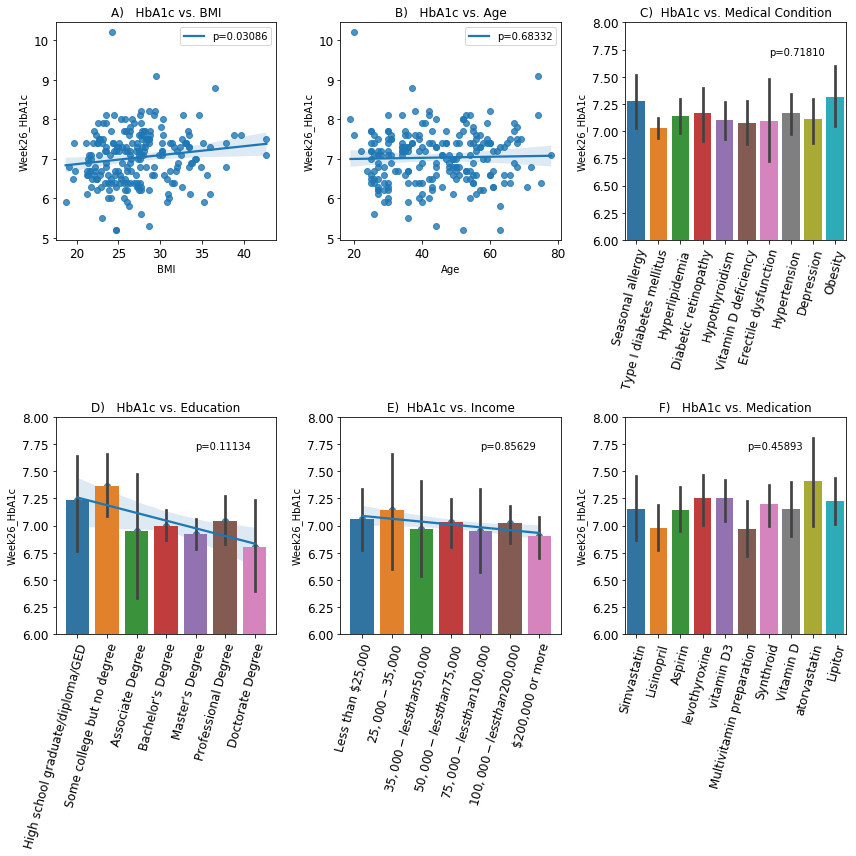

In [33]:
df = patientData[~patientData['Week26_HbA1c'].isna()]
fig, ax = plt.subplots(2,3, figsize=(12,12))
# A) BMI:
ax[0][0].set_title('A)   HbA1c vs. BMI')
slope, intercept, r_value, p_value, std_err = stats.linregress(df['BMI'],df['Week26_HbA1c'])
sns.regplot(x='BMI', y='Week26_HbA1c', data = df, line_kws={'label': 'p={:.5f}'.format(p_value)}, ax=ax[0][0]) 
ax[0][0].legend()

# B) Age:
ax[0][1].set_title('B)   HbA1c vs. Age')
slope, intercept, r_value, p_value, std_err = stats.linregress(df['Age'],df['Week26_HbA1c'])
sns.regplot(x='Age', y='Week26_HbA1c', data = df, line_kws={'label': 'p={:.5f}'.format(p_value)}, ax=ax[0][1]) 
ax[0][1].legend()

# C) Medical conditions:
ax[0][2].set_title('C)  HbA1c vs. Medical Condition')
df_temp = medicalConditions.merge(df[['PtID','Week26_HbA1c']], on='PtID', how='left').dropna()
groupVals=[]
for i, med in enumerate(commonMedCond_counts.MedCond.values):
    groupVals.append(df_temp[df_temp['MedCond']==commonMedCond_counts.MedCond.values[i]]['Week26_HbA1c'])
F_value, p_value = stats.f_oneway(*groupVals)
sns.barplot(x='MedCond', y='Week26_HbA1c', data = df_temp, label='p={:.5f}'.format(p_value),ax=ax[0][2])
plt.setp(ax[0][2].get_xticklabels(), rotation=75, ha="right", rotation_mode="anchor")
ax[0][2].annotate('p={:.5f}'.format(p_value), (6,7.7))
ax[0][2].set_xlabel(None)
ax[0][2].set_ylim([6,8])

# D) Medication:
ax[1][2].set_title('F)   HbA1c vs. Medication')
df_temp = medications.merge(df[['PtID','Week26_HbA1c']], on='PtID', how='left').dropna()
groupVals=[]
for i, med in enumerate(commonMed_counts.DrugName.values):
    groupVals.append(df_temp[df_temp['DrugName']==commonMed_counts.DrugName.values[i]]['Week26_HbA1c'])
F_value, p_value = stats.f_oneway(*groupVals)
sns.barplot(x='DrugName', y='Week26_HbA1c', data = df_temp, label='p={:.5f}'.format(p_value),ax=ax[1][2])
plt.setp(ax[1][2].get_xticklabels(), rotation=75, ha="right", rotation_mode="anchor")
ax[1][2].annotate('p={:.5f}'.format(p_value), (5,7.7))
ax[1][2].set_xlabel(None)
ax[1][2].set_ylim([6,8])

# Education level:
ax[1][0].set_title('D)   HbA1c vs. Education')
groupVals=[]
for i, med in enumerate(edu_order):
    groupVals.append(df[df['EduLevel']==edu_order[i]]['Week26_HbA1c'])

H_value, p_value = stats.kruskal(*groupVals)
sns.barplot(x='EduLevel', y='Week26_HbA1c', data = df, ax=ax[1][0])
sns.regplot(x=np.arange(0,len(inc_order)), y=df.groupby('EduLevel').mean()['Week26_HbA1c'], 
            ax=ax[1][0])
ax[1][0].annotate('p={:.5f}'.format(p_value), (4,7.7))
plt.setp(ax[1][0].get_xticklabels(), rotation=75, ha="right", rotation_mode="anchor")
ax[1][0].set_ylim([6,8])
ax[1][0].set_xlabel(None)

# Annual Income:
ax[1][1].set_title('E)  HbA1c vs. Income')
groupVals=[]
for i, med in enumerate(inc_order):
    groupVals.append(df[df['AnnualInc']==inc_order[i]]['Week26_HbA1c'])
H_value, p_value = stats.kruskal(*groupVals)
sns.barplot(x='AnnualInc', y='Week26_HbA1c', data = df, ax=ax[1][1], label='p={:.5f}'.format(p_value))
sns.regplot(x=np.arange(0,len(inc_order)), y=df.groupby('AnnualInc').mean()['Week26_HbA1c'], 
            ax=ax[1][1])
ax[1][1].annotate('p={:.5f}'.format(p_value), (4,7.7))
plt.setp(ax[1][1].get_xticklabels(), rotation=75, ha="right", rotation_mode="anchor")
ax[1][1].set_ylim([6,8])
ax[1][1].set_xlabel(None)

plt.tight_layout()
plt.show()

A) BMI is correlated with HbA1c levels (p=0.03086)
B) Age does not seem to be related to HbA1c levels (p=0.6833)
C) There are slight variations in HbA1c levels across patients with different pre-existing conditions, but overall there wasn't anything significant. (p=0.7180: one-way ANOVA)
D) Education tends to be negatively associated with HbA1c levels, suggesting better glucose control in more educated populations. (p=0.11134: Kruskal-Wallis test)
E) Income was also negatively correlated with HbA1c levels, but this wasn't statistically significant. (p=0.85629: Kruskal-Wallis test)
C) There are slight variations in HbA1c levels across patients with using different medications, but overall there wasn't anything significant. (p=0.45893: one-way ANOVA)

### B) Train a basic linear model and Lasso regression model to predict HbA1c using non-CGM data

const                       4.964490
Age                         0.013335
EduLevel                    0.000000
Gender                      0.000000
DiagAge                     0.000000
AnnualInc                  -0.021436
BMI                         0.055509
Hyperlipidemia              0.000000
Hypertension                0.000000
Hypothyroidism              0.000000
Depression                  0.000000
Vitamin D deficiency        0.000000
Seasonal allergy            0.000000
Erectile dysfunction        0.000000
Diabetic retinopathy        0.000000
Obesity                     0.000000
Lisinopril                  0.000000
Aspirin                     0.000000
Multivitamin preparation    0.000000
Vitamin D                   0.000000
Simvastatin                 0.000000
Synthroid                   0.000000
levothyroxine               0.000000
Lipitor                     0.000000
vitamin D3                  0.000000
atorvastatin                0.000000
Asian                       0.000000
B

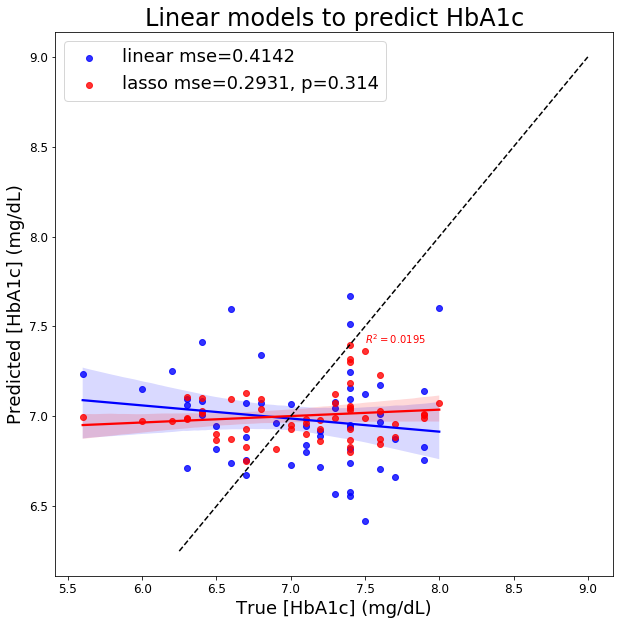

In [34]:
y = df['Week26_HbA1c']
X = df[['Age', 'EduLevel', 'Gender', 'DiagAge',
       'AnnualInc', 'BMI', 'Hyperlipidemia', 'Hypertension',
       'Hypothyroidism', 'Depression', 'Vitamin D deficiency',
                 'Lisinopril', 'Aspirin', 'Multivitamin preparation',
       'Vitamin D', 'Simvastatin', 'Synthroid', 'levothyroxine', 'Lipitor',
       'vitamin D3', 'atorvastatin',
       'Seasonal allergy', 'Erectile dysfunction', 'Diabetic retinopathy',
       'Obesity','Asian', 'Black/African American', 'More than one race', 'White']]
# Exclude 1 race column to account for appropriate degrees of freedom

# Convert Ordinal data to codes: 
X[['EduLevel', 'AnnualInc','Gender']] = X[['EduLevel', 'AnnualInc','Gender']].apply(lambda col:pd.Categorical(col).codes)

X_sm = sm.add_constant(X[['Age', 'EduLevel', 'Gender', 'DiagAge', 'AnnualInc', 'BMI',
   'Hyperlipidemia', 'Hypertension','Hypothyroidism', 'Depression', 
   'Vitamin D deficiency', 'Seasonal allergy', 'Erectile dysfunction', 
   'Diabetic retinopathy', 'Obesity','Lisinopril', 'Aspirin', 'Multivitamin preparation',
       'Vitamin D', 'Simvastatin', 'Synthroid', 'levothyroxine', 'Lipitor',
       'vitamin D3', 'atorvastatin', 'Asian', 'Black/African American',
   'More than one race', 'White']])

X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.25, random_state=1)
# X.columns

linear_regr = LinearRegression()
linear_regr.fit(X_train, y_train)
plt.figure(figsize=(10,10))
sns.regplot(y_test, linear_regr.predict(X_test),color='b', label='linear mse={:.4f}'.format(mean_squared_error(y_test, linear_regr.predict(X_test))))

lasso_regr = LassoCV(cv=5, random_state=0)
lasso_regr.fit(X_train, y_train)

lasso_stats_regr = sm.OLS(y, X_sm)
lasso_stats_regr_results = lasso_stats_regr.fit_regularized(method='elastic_net', alpha=lasso_regr.alpha_, L1_wt=1.0)
print(lasso_stats_regr_results.params)
# print(lasso_regr.alpha_)
# print(lasso_regr.coef_)
predict_regr =sm.OLS(y_test, sm.add_constant(lasso_regr.predict(X_test)))
result = predict_regr.fit()

sns.regplot(y_test, lasso_regr.predict(X_test),color='r', label='lasso mse={:.4f}, p={:.3f}'.format(mean_squared_error(y_test, lasso_regr.predict(X_test)), result.pvalues[1]))
plt.annotate('$R^2=$' + '{:.4f}'.format(result.rsquared),(7.5,7.4),color='red')
plt.plot(np.linspace(6.25,9,10),np.linspace(6.25,9,10), linestyle='--', color='k')
# plt.xlim([6.25,8.75])
# plt.ylim([6.25,8.75])
plt.ylabel('Predicted [HbA1c] (mg/dL)',FontSize=18)
plt.xlabel('True [HbA1c] (mg/dL)',FontSize=18)
plt.legend(fontsize=18)
plt.title("Linear models to predict HbA1c", FontSize=24)
plt.show()

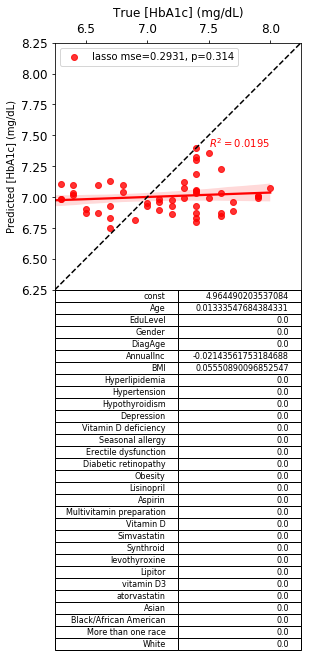

In [35]:
fig = plt.figure(figsize=(15, 10))
grid = plt.GridSpec(2, 3)
main_ax = fig.add_subplot(grid[0, 1])
sns.regplot(y_test, lasso_regr.predict(X_test),color='r', 
            label='lasso mse={:.4f}, p={:.3f}'.format(mean_squared_error(y_test, lasso_regr.predict(X_test)), result.pvalues[1]),
           ax=main_ax)
main_ax.xaxis.tick_top()
main_ax.plot()
main_ax.annotate('$R^2=$' + '{:.4f}'.format(result.rsquared),(7.5,7.4),color='red')
main_ax.plot(np.linspace(6.25,8.25,10),np.linspace(6.25,8.25,10), linestyle='--', color='k')

main_ax.set_xlabel(None)
main_ax.set_ylabel('Predicted [HbA1c] (mg/dL)')
main_ax.set_title('True [HbA1c] (mg/dL)')
main_ax.set_xlim([6.25, 8.25])
main_ax.set_ylim([6.25, 8.25])
main_ax.table(cellText=list(zip(lasso_stats_regr_results.params.index, lasso_stats_regr_results.params)))
main_ax.legend()
plt.show()